# Subgraphs

Useful in creating multi agent systems.

There are 2 ways how to utilize subgraphs:

## 1. Register subgraph as a node

```
builder.add_node("sub_graph", graph_builder.compile())
```

## 2. Invoke a subgraph from a node

```
def sub_graph_node(state: State) -> State:
    sub_graph.invoke({"question": "should i invest in AI stocks now"})
```

In [1]:
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from langgraph.graph import StateGraph, START, END

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults


from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

![Subgraphs](images/subgraphs.png)

## Optimized Web Search Graph

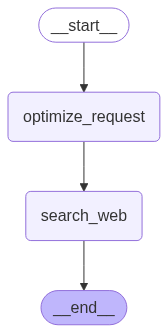

In [2]:
from langchain_community.tools import TavilySearchResults

class OptimizedWebSearchState(TypedDict):
    question: List[str]
    classification: List[str]
    optimized_web_request: str
    documents: List[str]


def optimize_request(state: OptimizedWebSearchState):
    system_message = SystemMessage(content=("""
        You are a query optimization assistant.  
        You receive two inputs:  
            - `category`: The predefined category of the query.  
            - `user_request`: The original user query.  

        Your task is to refine user queries for better search results while ensuring 
        relevance to the given category. Keep the original intent but improve clarity, 
        specificity, and structure.  

        - **Do not return a short, vague phrase.** The query must be structured for search engines to retrieve high-quality results.  
        - **Convert questions into search-friendly statements.** Do not return a question.  
        - **Ensure the query is fact-based**—remove subjective or vague phrasing like “should I,” “is it a good idea,” or “viable option.”  
        - **Use the category to improve relevance** but do not assume unnecessary details.  
        - **Never add a specific year unless the user explicitly includes one.** If a time reference is needed, use ‘now’ instead.  
        - **If the query is broad, narrow it down** by adding relevant **context** (e.g., key factors, market trends, risks, industries).  
        - **Avoid single-word or ultra-short responses.** The optimized query must be **concise but meaningful**.  

        Return **only the optimized query as plain text**, with no explanations, formatting, or extra text—just the improved query.
    """))

    human_message = HumanMessage(content=(f"""
        category: {state["classification"][0]}

        user_request: {state["question"][0]}
    """))
    
    optimized_web_request = llm.invoke([system_message, human_message])

    return {"optimized_web_request": optimized_web_request.content}


def search_web(state: OptimizedWebSearchState):
    tavily_search = TavilySearchResults(max_results=10)
    search_docs = tavily_search.invoke(state['optimized_web_request'])

    # Keywords that indicate an error or access restriction
    forbidden_keywords = [
        "403 Forbidden", "Access denied", "CAPTCHA", 
        "has been denied", "not authorized", "verify you are a human"
    ]

    results = [
        f'<Document url="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in search_docs
        if not any(keyword.lower() in doc["content"].lower() for keyword in forbidden_keywords)
    ]

    return {"documents": results}


optimized_web_search_builder = StateGraph(OptimizedWebSearchState)
optimized_web_search_builder.add_node(optimize_request)
optimized_web_search_builder.add_node(search_web)

optimized_web_search_builder.add_edge(START, "optimize_request")
optimized_web_search_builder.add_edge("optimize_request", "search_web")
optimized_web_search_builder.add_edge("search_web", END)

graph = optimized_web_search_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from dotenv import load_dotenv
load_dotenv()


True

In [7]:
import os
tavily_search = TavilySearchResults(
    max_results=10,
    tavily_api_key=os.getenv("TAVILY_API_KEY")
)


In [8]:
result = graph.invoke({
    "question": ["should i invest in AI stocks now"],
    "classification": ["Investment Advice"]
})
result

{'question': ['should i invest in AI stocks now'],
 'classification': ['Investment Advice'],
 'optimized_web_request': 'Evaluating the potential risks and rewards of investing in AI stocks now.',
 'documents': ['<Document url="https://www.fidelity.com/learning-center/trading-investing/invest-in-ai-stocks">\nRisks of AI stocks  Questions around data privacy, algorithmic bias, job displacement, and autonomous decision-making remain largely unresolved. This uncertainty poses both a challenge and a risk for investors, as public trust and regulatory responses could significantly impact the future of AI companies.\n</Document>',
  '<Document url="https://www.usatoday.com/story/money/investing/2025/08/15/top-ai-stocks-to-buy-2025/85497361007/">\nAnalysts projections confirm a slowdown is coming with 2025 revenue expected to slow to 14%. That deceleration has weighed on results, and the\n</Document>',
  '<Document url="https://www.dealmaker.tech/content/understanding-ai-startup-valuations-tren

## Structured Wikipedia Lookup Graph

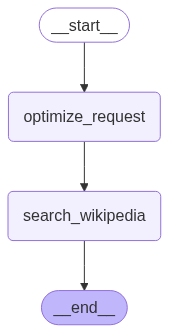

In [10]:
from langchain_community.document_loaders import WikipediaLoader

class StructuredWikipediaLookupState(TypedDict):
    question: List[str]
    classification: List[str]
    optimized_structured_wikipedia: str
    documents: List[str]


def optimize_request(state: StructuredWikipediaLookupState):
    system_message = SystemMessage(content=("""
        You optimize queries for searching Wikipedia articles.  
        You receive two inputs: 
            - `category`: The predefined category of the query. 
            - `user_request`: The original user query. 

        Use the **category** to refine the query while ensuring it aligns with Wikipedia's factual, encyclopedia-style content.  

            - **Never frame the query as a question.** Convert it into a Wikipedia-style article title.  
            - **Avoid subjective, speculative, or opinion-based wording.** Focus on factual, well-defined topics.  
            - **Ensure the optimized query is informative and structured as an encyclopedia entry.**  
            - **Use the category to guide query refinement** but do **not assume** or limit responses to a specific domain.  
            - **If the category suggests an advisory or decision-making topic (e.g., "Investment Advice"), shift the focus to established concepts, historical context, or factual analysis.**  

        Return **only the optimized query as plain text**, with no explanations, formatting, or extra text—just the improved query.
    """))

    human_message = HumanMessage(content=(f"""
        category: {state["classification"][0]}

        user_request: {state["question"][0]}
    """))
    
    optimized_structured_wikipedia = llm.invoke([system_message, human_message])

    return {"optimized_structured_wikipedia": optimized_structured_wikipedia.content}


def search_wikipedia(state: StructuredWikipediaLookupState):
    search_docs = WikipediaLoader(query=state['optimized_structured_wikipedia'], load_max_docs=10).load()

    results = [
        f'<Document url="{doc.metadata["source"]}">\n{doc.page_content}\n</Document>'
        for doc in search_docs
    ]
    
    return {"documents": results} 


structured_wikipedia_lookup_builder = StateGraph(StructuredWikipediaLookupState)
structured_wikipedia_lookup_builder.add_node(optimize_request)
structured_wikipedia_lookup_builder.add_node(search_wikipedia)

structured_wikipedia_lookup_builder.add_edge(START, "optimize_request")
structured_wikipedia_lookup_builder.add_edge("optimize_request", "search_wikipedia")
structured_wikipedia_lookup_builder.add_edge("search_wikipedia", END)

graph = structured_wikipedia_lookup_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({
    "question": ["should i invest in AI stocks now"],
    "classification": ["Investment Advice"]
})
result

{'question': ['should i invest in AI stocks now'],
 'classification': ['Investment Advice'],
 'optimized_structured_wikipedia': 'Investment in Artificial Intelligence Stocks: Trends and Considerations',
 'documents': ['<Document url="https://en.wikipedia.org/wiki/Exchange-traded_fund">\nAn exchange-traded fund (ETF) is a type of investment fund that is also an exchange-traded product; i.e., it is traded on stock exchanges. ETFs own financial assets such as stocks, bonds, currencies, debts, futures contracts, and/or commodities such as gold bars. Many ETFs provide some level of diversification compared to owning an individual stock.\n\n\n== Details ==\nAn ETF divides ownership of itself into shares that are held by shareholders. Depending on the country, the legal structure of an ETF can be a corporation, trust, open-end management investment company, or unit investment trust. Shareholders indirectly own the assets of the fund and are entitled to a share of the profits, such as interest

## Entire Graph

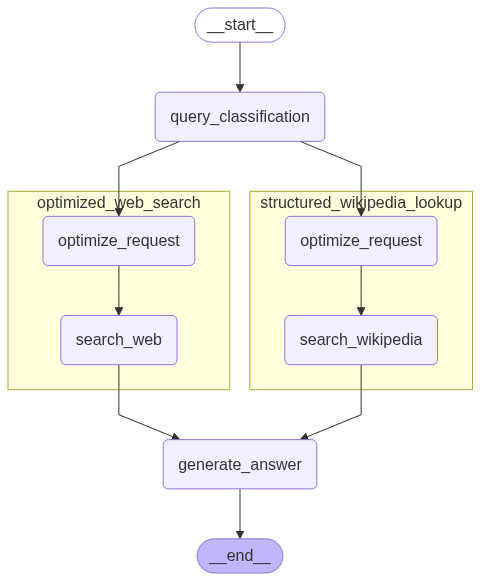

In [12]:
import operator

class EntireGraphState(TypedDict):
    question: Annotated[list, operator.add]
    classification: Annotated[list, operator.add]
    documents: Annotated[list, operator.add]
    answer: str


def query_classification(state: EntireGraphState):
    system_message = SystemMessage(content=("""
        You are a query classification assistant. Your task is to analyze user queries and assign 
        them to the most relevant category. Do not force-fit queries into predefined categories—only 
        use an existing category if it is a clear match. Otherwise, create a new category that 
        accurately represents the topic.
	        - Assign a category based on the core subject of the query.
	        - If the query clearly fits an existing category, use it.
	        - If no existing category is a perfect match, create a new descriptive category.
	        - Do not return ‘unknown’—always generate a meaningful category name.
	    
        Return only the category name as plain text, without explanations or extra text.
    """))

    classification = llm.invoke([system_message, HumanMessage(content=state["question"][0])])

    return {"classification": [classification.content]}


def generate_answer(state: EntireGraphState):
    # System message
    system_message = SystemMessage(content=("""
        You are an AI assistant that answers questions based on the provided documents.  

        ### **Guidelines:**  
            - Provide **direct, concise, and accurate** answers.  
            - When possible, **cite the relevant document or URL** next to the information used.  
            - If multiple documents contain relevant information, **synthesize the best answer** while ensuring clarity.  
            - If a document contains **conflicting information**, mention both perspectives.  
            - **When using a specific document for a prediction or key statement, include its source URL immediately after the referenced information** so the user can verify details.
    """))


    formatted_docs = "\n".join(
        [f"- {doc}" for doc in state["documents"]]
    )

    system_context = SystemMessage(content=(f"Use the following documents as context for your response:\n\n{formatted_docs}"))

    answer = llm.invoke([system_message, system_context, HumanMessage(content=state["question"][0])])
    
    # Append it to state
    return {"answer": answer}


builder = StateGraph(EntireGraphState)
builder.add_node(query_classification)
builder.add_node("optimized_web_search", optimized_web_search_builder.compile())
builder.add_node("structured_wikipedia_lookup", structured_wikipedia_lookup_builder.compile())
builder.add_node(generate_answer)

builder.add_edge(START, "query_classification")
builder.add_edge("query_classification", "optimized_web_search")
builder.add_edge("query_classification", "structured_wikipedia_lookup")
builder.add_edge("optimized_web_search", "generate_answer")
builder.add_edge("structured_wikipedia_lookup", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
result = graph.invoke({"question": ["should i invest in AI stocks now"]})
result

{'question': ['should i invest in AI stocks now',
  'should i invest in AI stocks now',
  'should i invest in AI stocks now'],
 'classification': ['Investment Advice',
  'Investment Advice',
  'Investment Advice'],
 'documents': ['<Document url="https://global.morningstar.com/en-gb/funds/artificial-intelligence-defining-investment-theme-our-era">\nInvesting in artificial intelligence offers high growth while harboring elevated risk · While most AI-focused funds and ETFs are in Europe, their\n</Document>',
  '<Document url="https://www.fool.com/investing/2025/08/16/5-top-artificial-intelligence-stocks-to-buy-in-aug/">\n5 Top Artificial Intelligence Stocks to Buy in August · 1. Nvidia · 2. Palantir Technologies · 3. Alphabet · 4. Broadcom · 5. GitLab.\n</Document>',
  '<Document url="https://www.usatoday.com/story/money/investing/2025/08/15/top-ai-stocks-to-buy-2025/85497361007/">\nThe Motley Fool recommends the following options: long January 2026 $395 calls on Microsoft, short August 2

In [14]:
print(result["answer"].content)

Investing in AI stocks can present high growth potential, but it also carries elevated risks. It’s important to consider both the potential rewards and the inherent complexities and uncertainties that come with investing in this sector.

Currently, notable AI stocks include Nvidia, Palantir Technologies, Alphabet, Broadcom, and GitLab, which are highlighted for their promising performance and sector alignments. In addition, companies like Microsoft and Intel have specific options strategies outlined, indicating investor interest. The robust demand for AI-related technology, driven by advancements in quality and automation, supports a positive outlook for the industry (source: https://global.morningstar.com/en-gb/funds/artificial-intelligence-defining-investment-theme-our-era; https://www.fool.com/investing/2025/08/16/5-top-artificial-intelligence-stocks-to-buy-in-aug/).

However, potential downsides include issues related to the complexity, opacity, and bias of AI applications, which c